<a href="https://colab.research.google.com/github/rakesh4real/one-or-few-shot-learning/blob/main/siamese_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random, time, pickle, os
import numpy as np
import matplotlib.pyplot as plt   

import torch
import torch.nn as nn
from torchvision import datasets
from torch.autograd import Variable
from torchvision import transforms

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    print('Seed is: ', seed)
    
    
SEED = 123
seed_everything(SEED)

Seed is:  123


# 1. Prepare Dataset

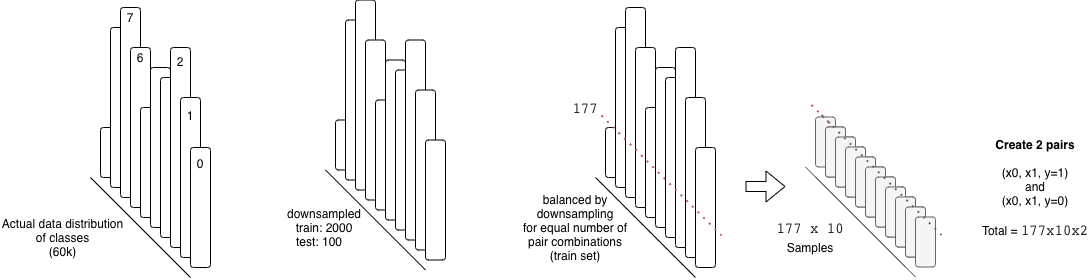

In [4]:
class DatasetIterator:
    '''
    Input: numpy values
    Output: torch variables.
    '''
    def __init__(self, x0, x1, label):
        self.size = label.shape[0] 
        self.x0 = torch.from_numpy(x0)
        self.x1 = torch.from_numpy(x1)
        self.label = torch.from_numpy(label)

    def __getitem__(self, index):
        return (self.x0[index],
                self.x1[index],
                self.label[index])

    def __len__(self):
        return self.size

In [5]:
def create_pairs(data, digit_indices):
    '''
    input
    -----
      data: 
        xs (downsampled data)
      digit_indices: 
        `n_classes` sized list. 
        Each idx corresponding to the actual class 
        label and the location of all those class 
        samples in whole dataset
    '''
    
    x0_data = []
    x1_data = []
    label = []
    
    # downsample dataset to the size of class with least
    # sample points. Cz, equal number of pairs must be formed.
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    
    print('Downsample each class to: ', n, ' sample points')
    print(f'Total pairs per label = {n}*10 = {n*10}')
    print(f'Total similar and dissimilar combinations = 2*{n*10} = {2*n*10}')
    print("\n\n")

    for d in range(10): # for all 10 classes
        for i in range(n): 
            # 10*177

            # similar pairs (y=1)
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            x0_data.append(data[z1] / 255.) 
            x1_data.append(data[z2] / 255.) 
            label.append(1)
            
            # dissimilar pairs (y=2) [randomly]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            x0_data.append(data[z1] / 255.) 
            x1_data.append(data[z2] / 255.)
            label.append(0)

    x0_data = np.array(x0_data, dtype=np.float32)
    x0_data = x0_data.reshape([-1, 1, 28, 28])
    x1_data = np.array(x1_data, dtype=np.float32)
    x1_data = x1_data.reshape([-1, 1, 28, 28])
    label = np.array(label, dtype=np.int32)
    return x0_data, x1_data, label

In [6]:
def create_iterator(data, label): 
    '''
    input   : xs, label (i.e data, actual_labels)
    output  : x0, x1, similar_or_not (iterator)
    '''

    digit_indices = [np.where(label == i)[0] for i in range(10)]
    x0, x1, label = create_pairs(data, digit_indices)
    return DatasetIterator(x0, x1, label)

In [7]:
train_sample_size = 2000
test_sample_size = 100

train = datasets.MNIST(root='../data/',train=True,download=True)
test = datasets.MNIST(root='../data/',train=False,transform=transforms.Compose([transforms.ToTensor(),]))

indices_train= np.random.choice(len(train.targets.numpy()), train_sample_size, replace=False)
indices_test= np.random.choice(len(test.targets.numpy()), test_sample_size, replace=False)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [8]:
print('sampled train size: ', len(indices_train))
print('sampled test size: ', len(indices_test))

sampled train size:  2000
sampled test size:  100


In [9]:
train_iter = create_iterator(
    train.data.numpy()[indices_train],
    train.targets.numpy()[indices_train])

test_iter = create_iterator(
    test.data.numpy()[indices_test],
    test.targets.numpy()[indices_test])

Downsample each class to:  177  sample points
Total pairs per label = 177*10 = 1770
Total similar and dissimilar combinations = 2*1770 = 3540



Downsample each class to:  3  sample points
Total pairs per label = 3*10 = 30
Total similar and dissimilar combinations = 2*30 = 60





In [10]:
_x0, _x1, _y = next(iter(train_iter))

print("pairs' shape: ", _x0.shape, _x1.shape)
print('numeric label: ', _y) # binary classification

print("\n")
print('size of train iter: ', len(train_iter))
print('size of test iter: ', len(test_iter))

pairs' shape:  torch.Size([1, 28, 28]) torch.Size([1, 28, 28])
numeric label:  tensor(1, dtype=torch.int32)


size of train iter:  3540
size of test iter:  60


## 2. Loss Function

$
\text{Euc. Dist. b/w similar dissimilar pairs: }$

$$ D = ||f(x_0) - f(x_1)||_2 = \sqrt[2]{\big[f(x_0) - f(x_1)\big]^2} 
 \text{where $f$ is siamese network}$$

- For similar pairs
  - Minimize $D$. It must be **small**.
  - Minimum possible value must be `0` (loss cannot be negative). So, use $max(0, D)$
  - $D$ can be easily made $0$ by $ W \rightarrow 0$. Avoid it by using margin. So, use $max(0, m-D)$ 
- For dissimilar pairs
  - <strike>Maximize $D$ </strike>
  - Behave like regression loss and learn features (minimize $D$)
- Square whole $D$ term for penalisation of loss

<br>
$$
L(x_0, x_1, y, \theta) = \begin{cases} 
 \bigg(max(0, \, m-D)\bigg)^2 & \text{if similar i.e $y = 1$} \\  
 D^2 & \text{if dissimilar i.e $y = 0$} \\  
 \end{cases} 
$$

To write both cases in single eqn, take halves from both cases

$$
L(x_0, x_1, y, \theta) = \frac{1}{2} (y) \bigg(max(0, \, m-D)\bigg)^2 + \frac{1}{2} (1-y) D^2
$$

**Disadvantages:**  

- Not able to learn decision boundaries very clearly.
- Need to configure hyperparam $m$
- Triplet loss is better

In [11]:
def contrastive_loss_function(x0, x1, y, margin=1.0):
    diff = x0 - x1 # euc. dist
    dist_sq = torch.sum(torch.pow(diff, 2), 1) # D^2
    D = torch.sqrt(dist_sq)

    mdist = margin - D
    dist = torch.clamp(mdist, min=0.0) 
    
    loss = y * dist_sq + (1 - y) * torch.pow(dist, 2)
    loss = torch.sum(loss) / 2.0 / x0.size()[0]
    
    return loss

## 3. Siamese Network

In [12]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 20, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(20, 50, kernel_size=5),
            nn.MaxPool2d(2, stride=2))
        self.fc1 = nn.Sequential(
            nn.Linear(50 * 4 * 4, 500),
            nn.ReLU(inplace=True),
            nn.Linear(500,10),
            nn.Linear(10, 2))
        
    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

## 4. Hyperparameters and training configuration

In [13]:
# call model
model = SiameseNetwork().to(device)
lr = 0.01
momentum = 0.9
batchsize = 128

# Loss and Optimizer
criterion = contrastive_loss_function # we will use contrastive loss function as defined above
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

# creating a train loader, and a test loader.
# batchsize will reflect here
train_loader = torch.utils.data.DataLoader(train_iter,batch_size=batchsize, shuffle=True)
test_loader = torch.utils.data.DataLoader(test,batch_size=batchsize, shuffle=True)

In [14]:
_x0, _x1, _y = next(iter(train_loader))

print("pairs' shape: ", _x0.shape, _x1.shape)
print('labels of batch: ', _y)

print("\n")
print('size of train iter: ', len(train_iter))
print('size of test iter: ', len(test_iter))

# with batchsize

pairs' shape:  torch.Size([128, 1, 28, 28]) torch.Size([128, 1, 28, 28])
labels of batch:  tensor([1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
        0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1,
        1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
        1, 1, 0, 1, 1, 0, 0, 0], dtype=torch.int32)


size of train iter:  3540
size of test iter:  60


## 5. Train

In [15]:
train_loss = []
epochs =100
for epoch in range(epochs):
    for batch_idx, (x0, x1, labels) in enumerate(train_loader):
        labels = labels.float().to(device)
        x0, x1, labels = x0.to(device), x1.to(device), labels.to(device)
        output1, output2 = model(x0, x1)
        loss = criterion(output1, output2, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        if batch_idx % batchsize == 0:
            print('Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

Epoch: 0 	Loss: 0.225649
Epoch: 1 	Loss: 0.181692
Epoch: 2 	Loss: 0.113934
Epoch: 3 	Loss: 0.082056
Epoch: 4 	Loss: 0.069084
Epoch: 5 	Loss: 0.071780
Epoch: 6 	Loss: 0.066625
Epoch: 7 	Loss: 0.068588
Epoch: 8 	Loss: 0.064661
Epoch: 9 	Loss: 0.052253
Epoch: 10 	Loss: 0.061413
Epoch: 11 	Loss: 0.056016
Epoch: 12 	Loss: 0.047111
Epoch: 13 	Loss: 0.042304
Epoch: 14 	Loss: 0.047853
Epoch: 15 	Loss: 0.044545
Epoch: 16 	Loss: 0.045407
Epoch: 17 	Loss: 0.040212
Epoch: 18 	Loss: 0.045595
Epoch: 19 	Loss: 0.050634
Epoch: 20 	Loss: 0.037065
Epoch: 21 	Loss: 0.042055
Epoch: 22 	Loss: 0.040221
Epoch: 23 	Loss: 0.039594
Epoch: 24 	Loss: 0.037229
Epoch: 25 	Loss: 0.033244
Epoch: 26 	Loss: 0.041574
Epoch: 27 	Loss: 0.041400
Epoch: 28 	Loss: 0.030716
Epoch: 29 	Loss: 0.030134
Epoch: 30 	Loss: 0.034240
Epoch: 31 	Loss: 0.035196
Epoch: 32 	Loss: 0.032244
Epoch: 33 	Loss: 0.025658
Epoch: 34 	Loss: 0.021513
Epoch: 35 	Loss: 0.026811
Epoch: 36 	Loss: 0.031238
Epoch: 37 	Loss: 0.022408
Epoch: 38 	Loss: 0.031

In [16]:
def plot_loss(train_loss,name="train_loss.png"):
    plt.plot(train_loss, label="train loss")
    plt.legend()

def plot_mnist(numpy_all, numpy_labels,name="./embeddings_plot.png"):
        c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff',
             '#ff00ff', '#990000', '#999900', '#009900', '#009999']

        for i in range(10):
            f = numpy_all[np.where(numpy_labels == i)]
            plt.plot(f[:, 0], f[:, 1], '.', c=c[i])
        plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
        plt.savefig(name)

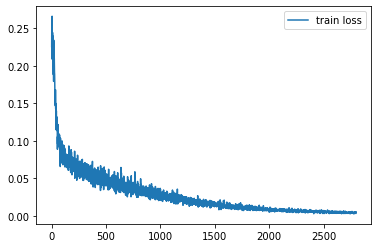

In [17]:
plot_loss(train_loss)

In [18]:
def test_model(model):
        model.eval()
        all_ = []
        all_labels = []
        with torch.no_grad():
            for batch_idx, (x, labels) in enumerate(test_loader):
                x, labels = x.to(device), labels.to(device)
                output = model.forward_once(x)
                all_.extend(output.data.cpu().numpy().tolist())
                all_labels.extend(labels.data.cpu().numpy().tolist())

        numpy_all = np.array(all_)
        numpy_labels = np.array(all_labels)
        return numpy_all, numpy_labels

def testing_plots(model):
        dict_pickle={}
        numpy_all, numpy_labels = test_model(model)
        dict_pickle["numpy_all"]=numpy_all
        dict_pickle["numpy_labels"]=numpy_labels
        plot_mnist(numpy_all, numpy_labels)

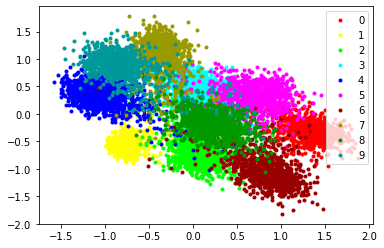

In [19]:
testing_plots(model)